In [6]:
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# LOAD DATA (UTILS) 

def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

def load_pickle_files(folder_path):
    env_data = None
    problem_data = []
    solution_data = []

    files = os.listdir(folder_path)

    for file_name in tqdm(files, desc="Loading files"):
        file_path = os.path.join(folder_path, file_name)

        # skip non-files
        if not os.path.isfile(file_path):
            continue

        if file_name == 'env.pickle':
            env_data = load_pickle(file_path)
        elif file_name.startswith('problem_') and file_name.endswith('.pickle'):
            problem_data.append(load_pickle(file_path))
        elif file_name.startswith('solution_') and file_name.endswith('.pickle'):
            solution_data.append(load_pickle(file_path))

    return env_data, problem_data, solution_data



# dir = '/Users/jakegonzales/Research/Amazon/data/train'
# folders = os.listdir(dir)

# all_env_data = []
# all_problem_data = []
# all_solution_data = []

# for folder in folders:
#     folder_path = os.path.join(dir, folder)

#     # skip non-directory entries
#     if not os.path.isdir(folder_path):
#         continue

#     # dicts with data 
#     env_data, problem_data, solution_data = load_pickle_files(folder_path)
    
#     # append data to respective lists
#     all_env_data.append(env_data)
#     all_problem_data.extend(problem_data)
#     all_solution_data.extend(solution_data)



In [8]:
import torch
from tqdm import tqdm

"""
BREAK DATA INTO SUBREGION DATA RATHER THAN FULL GRID DATA

"""

class SubregionDataProcessor:
    def __init__(self, env_data, problem_data, solution_data):
        self.env_data = env_data
        self.problem_data = problem_data
        self.solution_data = solution_data
        self.subregion_nodes = self.divide_subregions()
        
    def filter_solutions(self, problem_data, solution_data):
        # Filter out problems without solutions
        filtered_problem_data = []
        filtered_solution_data = []

        for problem, solution in zip(problem_data, solution_data):
            if problem is not None and solution is not None:
                filtered_problem_data.append(problem)
                filtered_solution_data.append(solution)

        return filtered_problem_data, filtered_solution_data

    def divide_subregions(self):
        subregion_nodes = []

        grid_nodes = self.env_data[0]['grid_nodes']

        subregion_nodes_dict = {f'subregion_{i}': [] for i in range(1, 26)}

        for node in grid_nodes:
            subregion_i = node[0] // 16  
            subregion_j = node[1] // 16 
            subregion_index = subregion_i * 5 + subregion_j

            subregion_label = f'subregion_{subregion_index + 1}' 
            subregion_nodes_dict[subregion_label].append(node)

        subregion_nodes.append(subregion_nodes_dict)

        return subregion_nodes

    def divide_subregion_paths(self):
        subregion_paths = []

        paths = [data['paths'] for data in self.solution_data]

        for path_data in tqdm(paths, desc="Processing paths"):
            subregion_path_data = {}
            for agent_id, agent_path in path_data.items():
                subregion_path = {}
                for node, timestep in agent_path:
                    for subregion_id, nodes in self.subregion_nodes[0].items():
                        if node in nodes:
                            subregion_path.setdefault(subregion_id, []).append((node, timestep))
                            break
                subregion_path_data[agent_id] = subregion_path
            subregion_paths.append(subregion_path_data)

        return subregion_paths

    def convert_to_tensor(self, subregion_paths):
        """
        Convert subregion_paths data into PyTorch tensors
        """
        tensor_data = []
        for path_data in subregion_paths:
            agent_paths = []
            for agent_id, subregion_path in path_data.items():
                path_tensors = []
                for subregion_id, subregion_data in subregion_path.items():
                    node_indices = []
                    timestamps = []
                    for node, timestamp in subregion_data:
                        node_indices.append(node)
                        timestamps.append(timestamp)
                    node_indices_tensor = torch.tensor(node_indices)
                    timestamps_tensor = torch.tensor(timestamps)
                    path_tensors.append((node_indices_tensor, timestamps_tensor))
                agent_paths.append(path_tensors)
            tensor_data.append(agent_paths)
        return tensor_data


# # Create instance of SubregionDataProcessor
# processor = SubregionDataProcessor(all_env_data, all_problem_data, all_solution_data)

# processor.filter_solutions(problem_data, solution_data)
# subregion_nodes = processor.divide_subregions()
# subregion_paths = processor.divide_subregion_paths()
# subregion_paths_tensor = processor.convert_to_tensor(subregion_paths)





In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

"""
Create custom dataset to use in GCN

"""

class CBSPathDataset(Dataset):
    def __init__(self, start_positions, destinations, paths):
        self.start_positions = start_positions
        self.destinations = destinations
        self.paths = paths

    def __len__(self):
        return len(self.start_positions)

    def __getitem__(self, idx):
        origin = self.start_positions[idx]
        destination = self.destinations[idx]
        path = self.paths[idx]

        return origin, destination, path

def collate_fn(batch):
    """
    function to deal with variable-length tensors in dataset

    """
    origins, destinations, paths = zip(*batch)

    # Pad sequences to the maximum length in the batch
    padded_paths = pad_sequence(paths, batch_first=True)

    return torch.stack(origins), torch.stack(destinations), padded_paths

def get_origin_destinations_paths(subregion_paths):
    origins = []
    destinations = []
    paths = []

    for agent_paths in tqdm(subregion_paths, desc="Processing O-D"):
        for path_data in agent_paths.values():
            for path in path_data.values():
                start_pos = path[0][0]
                origins.append(start_pos)
                
                destination = path[-1][0]
                destinations.append(destination)

                path_nodes = [node for node, _ in path]
                paths.append(path_nodes)
                
    origins_tensor = torch.tensor(origins)
    destinations_tensor = torch.tensor(destinations)
    paths_tensor = [torch.tensor(p) for p in paths]

    return origins_tensor, destinations_tensor, paths_tensor


# origins_tensor, destinations_tensor, paths_tensor = get_origin_destinations_paths(subregion_paths)

# dataset = CBSPathDataset(origins_tensor, destinations_tensor, paths_tensor)
# data_loader = DataLoader(dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# for batch_idx, (origins_tensor, destinations_tensor, paths_tensor) in tqdm(enumerate(data_loader), desc="Processing Batches"):
#     #print("Batch:", batch_idx)

#     # use in GCN
#     origins = origins_tensor
#     destinations = destinations_tensor
#     paths = paths_tensor
    
# print("Batch Completed")




In [10]:
"""
Load training and test datasets

takes ~ 15 mins to run

"""

def load_train_data(): 

    print("Loading Train Dataset...")

    dir = '/Users/jakegonzales/Research/Amazon/data/train'
    folders = os.listdir(dir)
    
    all_env_data = []
    all_problem_data = []
    all_solution_data = []
    
    for folder in folders:
        folder_path = os.path.join(dir, folder)
    
        # skip non-directory entries
        if not os.path.isdir(folder_path):
            continue
    
        # dicts with data 
        env_data, problem_data, solution_data = load_pickle_files(folder_path)
        
        # append data to respective lists
        all_env_data.append(env_data)
        all_problem_data.extend(problem_data)
        all_solution_data.extend(solution_data)

    print("pickle files loaded.")
    
    # Create instance of SubregionDataProcessor
    processor = SubregionDataProcessor(all_env_data, all_problem_data, all_solution_data)
    # break data into subregions
    processor.filter_solutions(all_problem_data, all_solution_data)
    subregion_nodes = processor.divide_subregions()
    subregion_paths = processor.divide_subregion_paths()
    subregion_paths_tensor = processor.convert_to_tensor(subregion_paths)

    print("subregion data loaded.")

    # get origins, desetinations and paths from subregion paths
    origins_tensor, destinations_tensor, paths_tensor = get_origin_destinations_paths(subregion_paths)
    # load pytorch tensors using custom dataloader

    train_dataset = CBSPathDataset(origins_tensor, destinations_tensor, paths_tensor)

    return train_dataset, subregion_nodes

def load_test_data(): 

    print("Loading Test Dataset...")

    dir = '/Users/jakegonzales/Research/Amazon/data/test'
    folders = os.listdir(dir)
    
    all_env_data = []
    all_problem_data = []
    all_solution_data = []
    
    for folder in folders:
        folder_path = os.path.join(dir, folder)
    
        # skip non-directory entries
        if not os.path.isdir(folder_path):
            continue
    
        # dicts with data 
        env_data, problem_data, solution_data = load_pickle_files(folder_path)
        
        # append data to respective lists
        all_env_data.append(env_data)
        all_problem_data.extend(problem_data)
        all_solution_data.extend(solution_data)

    print("pickle files loaded.")
    
    # Create instance of SubregionDataProcessor
    processor = SubregionDataProcessor(all_env_data, all_problem_data, all_solution_data)
    # break data into subregions
    processor.filter_solutions(all_problem_data, all_solution_data)
    subregion_nodes = processor.divide_subregions()
    subregion_paths = processor.divide_subregion_paths()
    subregion_paths_tensor = processor.convert_to_tensor(subregion_paths)

    print("subregion data loaded.")
    
    # get origins, desetinations and paths from subregion paths
    origins_tensor, destinations_tensor, paths_tensor = get_origin_destinations_paths(subregion_paths)

    test_dataset = CBSPathDataset(origins_tensor, destinations_tensor, paths_tensor)

    return test_dataset

train_dataset, subregion_nodes = load_train_data()    
print("Loaded Train Dataset. \n")
test_dataset  = load_test_data()
print("Loaded Test Dataset.") 
    


Loading Train Dataset...


Loading files: 100%|████████████████████████| 5410/5410 [01:11<00:00, 75.82it/s]


pickle files loaded.


Processing paths: 100%|█████████████████████| 7611/7611 [15:38<00:00,  8.11it/s]


subregion data loaded.


Processing O-D: 100%|██████████████████████| 7611/7611 [00:09<00:00, 840.55it/s]


Loaded Train Dataset.
Loading Test Dataset...


Loading files: 100%|███████████████████████| 5278/5278 [00:19<00:00, 270.01it/s]


pickle files loaded.


Processing paths: 100%|█████████████████████| 2467/2467 [05:00<00:00,  8.21it/s]


subregion data loaded.


Processing O-D: 100%|██████████████████████| 2467/2467 [00:02<00:00, 869.00it/s]


Loaded Test Dataset.


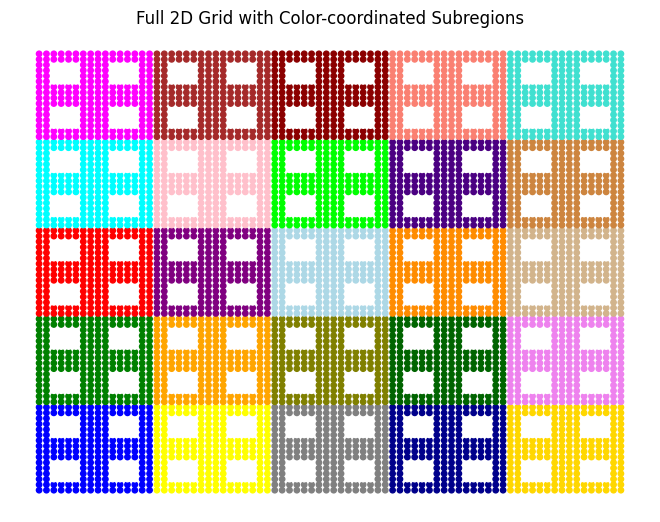

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

## FULL GRID VISUALIZATION WITH SUBREGION COLOR COORDINATION

def plot_subregions(subregion_nodes):

    nrows, ncols = 80, 80
    G = nx.Graph()
    for i in range(nrows):
        for j in range(ncols):
            G.add_node((i, j))

    colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'orange', 'purple', 'pink', 'brown',
              'gray', 'olive', 'lightblue', 'lime', 'darkred', 'darkblue', 'darkgreen', 'darkorange', 'indigo',
              'salmon', 'gold', 'violet', 'tan', 'peru', 'turquoise']

    node_colors = {}
    for subregion, nodes in subregion_nodes[0].items():
        color = colors[int(subregion.split('_')[1]) - 1]
        for node in nodes:
            node_colors[node] = color

    # assign obstacles white
    for node in G.nodes():
        if node not in node_colors:
            node_colors[node] = 'white' 

    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, node_color=[node_colors[node] for node in G.nodes()], with_labels=False, node_size=15)

    plt.title("Full 2D Grid with Color-coordinated Subregions")
    plt.show()

plot_subregions(subregion_nodes)


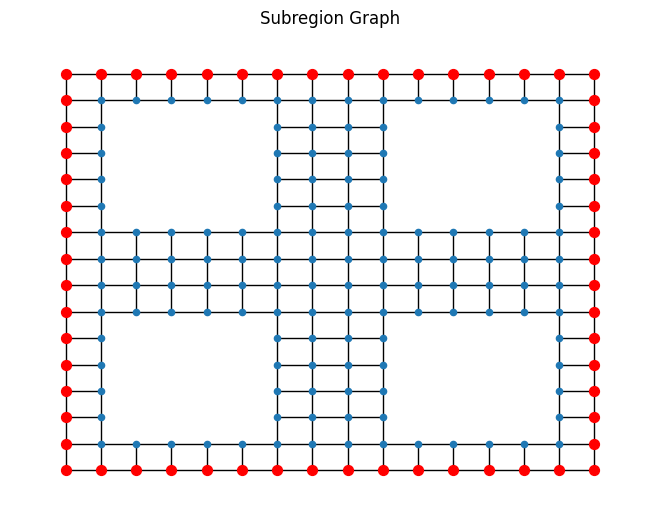

In [81]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.sparse as sparse


"""
UTILITY FUNCTIONS

"""

def normalize_adjacency(adj):
    """ Normalizes the adjacency matrix according to the
        paper by Kipf et al.
        https://arxiv.org/pdf/1609.02907.pdf
    """
    adj = adj + sparse.eye(adj.shape[0])

    node_degrees = np.array(adj.sum(1))
    node_degrees = np.power(node_degrees, -0.5).flatten()
    node_degrees[np.isinf(node_degrees)] = 0.0
    node_degrees[np.isnan(node_degrees)] = 0.0
    degree_matrix = sparse.diags(node_degrees, dtype=np.float32)

    adj = degree_matrix @ adj @ degree_matrix
    return adj

def convert_scipy_to_torch_sparse(matrix):
    matrix_helper_coo = matrix.tocoo().astype('float32')
    data = torch.FloatTensor(matrix_helper_coo.data)
    rows = torch.LongTensor(matrix_helper_coo.row)
    cols = torch.LongTensor(matrix_helper_coo.col)
    indices = torch.vstack([rows, cols])

    shape = torch.Size(matrix_helper_coo.shape)
    matrix = torch.sparse_coo_tensor(indices, data, shape)
    return matrix

def get_boundary_nodes(subregion_nodes):
    boundary_nodes = []
    nodes_list = subregion_nodes[0]['subregion_1']
    for node in nodes_list:
        x, y = node
        if x == 0 or x == 15 or y == 0 or y == 15:  # Assuming a 16x16 grid
            boundary_nodes.append(node)
    return boundary_nodes


"""
FULL GRID NETWORKX AND SPARSE ADJ MATRICES 

"""

def to_networkx(env_data): 
    # CREATE NETWORKX GRAPH BASED ON CBS ENV DATA 
    grid_adj = []
    for data in env_data:
        grid_adj.append(data['grid_adj'])
        
    grid_adj = grid_adj[0]

    G = nx.Graph()
    for node, neighbors in grid_adj.items():
        for neighbor in neighbors.keys():
            G.add_edge(node, neighbor)

    # dreate positions for nodes in a 2D grid layout
    pos = {node: node for node in G.nodes()}

    # draw the graph
    #plt.figure(figsize=(16, 16))
    #nx.draw(G, pos, with_labels=True, node_size=100, node_color='lightblue', font_size=10)
    #plt.title("Grid Graph Visualization")
    #plt.show()

    adj_matrix = nx.adjacency_matrix(G)
    adj_matrix = adj_matrix.todense()
    
    return adj_matrix

def load_graph_data(env_data):
    # ENV DATA IS FROM CBS
    grid_adj = []
    for data in env_data:
        grid_adj.append(data['grid_adj'])
        
    grid_adj = grid_adj[0]

    # Convert env grid adj to a dense matrix for comparison
    max_i = max(coord[0] for coord in grid_adj.keys())
    max_j = max(coord[1] for coord in grid_adj.keys())
    num_nodes = max(max_i, max_j) + 1 

    # Convert env grid adj to torch sparse adj matrix
    row_indices, col_indices = zip(*[(node[0], neighbor[1]) for node, neighbors in grid_adj.items() for neighbor in neighbors.keys()])
    data = torch.ones(len(row_indices))

    indices = torch.LongTensor([row_indices, col_indices])
    sparse_adj_matrix = torch.sparse_coo_tensor(indices, data, torch.Size([num_nodes, num_nodes]))

    return sparse_adj_matrix


"""
SUBREGION NETWORKX AND SPARSE COO ADJ MATRICES

"""

def subregion_graph(subregion_nodes, boundary_nodes): 
    first_subregion = list(subregion_nodes[0].keys())[0]
    nodes = subregion_nodes[0][first_subregion]

    max_row = max(node[0] for node in nodes)
    max_col = max(node[1] for node in nodes)

    G = nx.Graph()

    # add non-obstacle nodes to the graph
    G.add_nodes_from(nodes)

    # add edges between neighboring nodes that aren't obstacles
    for i in range(max_row + 1):
        for j in range(max_col + 1):
            current_node = (i, j)
            if current_node in nodes:  # check if the current node is not an obstacle
                # Check and add edges with neighboring nodes
                for neighbor in [(i-1, j), (i+1, j), (i, j-1), (i, j+1)]:
                    if neighbor in nodes:  # check if the neighbor is not an obstacle
                        G.add_edge(current_node, neighbor)

    # plot graph in 2D grid 
    pos = {node: node for node in G.nodes()}
    nx.draw(G, pos, with_labels=False, node_size=20)
    
    # Highlight boundary nodes in red
    nx.draw_networkx_nodes(G, pos, nodelist=boundary_nodes, node_color='r', node_size=50)
    
    plt.title("Subregion Graph")
    plt.show()

    # create adj matrix using networkx
    adj_nx = nx.adjacency_matrix(G)
    # Convert NetworkX adjacency matrix to SciPy sparse matrix
    adj_sparse = sparse.coo_matrix(adj_nx)

    # Make the adjacency matrix symmetric
    adj = adj_sparse + adj_sparse.T.multiply(adj_sparse.T > adj_sparse)
    adj_normalized = normalize_adjacency(adj)

    # convert to sparse pytorch tensor 
    subregion_adj = convert_scipy_to_torch_sparse(adj)

    return G, subregion_adj, adj_nx

## FULL GRID
# sparse_adj_matrix = load_graph_data(all_env_data)
# networkx_adj_matrix = to_networkx(all_env_data)

## SUBREGION GRID 
boundary_nodes = get_boundary_nodes(subregion_nodes)
subregion_G, subregion_adj, subregion_adj_nx = subregion_graph(subregion_nodes, boundary_nodes) # subregion_nodes from SubregionDataProcessor class



In [56]:
## Inspect training dataset

print(type(train_dataset))

# Iterate over the first 3 samples of the dataset and print each sample
for i in range(3):
    sample = train_dataset[i]
    print(f"Sample {i + 1}:")
    print("Start Positions:", sample[0])
    print("Destinations:", sample[1])
    print("Paths:", sample[2])
    print()

## Inspect sparse adjacency matrix for the subregion
adj = subregion_adj 
print(adj)

<class '__main__.CBSPathDataset'>
Sample 1:
Start Positions: tensor([76, 46])
Destinations: tensor([64, 46])
Paths: tensor([[76, 46],
        [75, 46],
        [74, 46],
        [73, 46],
        [72, 46],
        [71, 46],
        [70, 46],
        [69, 46],
        [68, 46],
        [67, 46],
        [66, 46],
        [65, 46],
        [64, 46]])

Sample 2:
Start Positions: tensor([63, 46])
Destinations: tensor([63, 47])
Paths: tensor([[63, 46],
        [63, 47]])

Sample 3:
Start Positions: tensor([63, 48])
Destinations: tensor([63, 63])
Paths: tensor([[63, 48],
        [63, 49],
        [63, 50],
        [63, 51],
        [63, 52],
        [63, 53],
        [63, 54],
        [63, 55],
        [63, 56],
        [63, 57],
        [63, 58],
        [63, 59],
        [63, 60],
        [63, 61],
        [63, 62],
        [63, 63]])

tensor(indices=tensor([[  0,   0,   1,  ..., 190, 191, 191],
                       [  1,  16,   0,  ..., 191, 175, 190]]),
       values=tensor([1., 1., 1.

In [82]:
import itertools
import torch

def get_congestion_matrix(subregion_adj):
    congestion_matrix = subregion_adj
    return congestion_matrix

def generate_labels_for_all_configurations(congestion_matrix, max_agents, boundary_nodes):
    """
    Generate labels representing the difference in time delays for every combination of agent configurations.
    
    Parameters:
        congestion_matrix (torch.sparse.FloatTensor): Sparse adjacency matrix representing congestion.
        max_agents (int): Maximum number of agents in any configuration.
        boundary_nodes (list of tuple): List of tuples representing boundary nodes.
    
    Returns:
        dict: Dictionary containing labels for each combination of configurations and boundary nodes.
    """
    all_labels = {}
    
    # Generate all possible combinations of agent configurations
    for num_agents in range(1, max_agents + 1):
        for configuration in itertools.combinations(boundary_nodes, num_agents):
            # Generate labels for the current configuration
            labels = generate_labels_for_configuration(congestion_matrix, configuration)
            # Add labels to the dictionary
            all_labels[num_agents, configuration] = labels
    
    return all_labels

def generate_labels_for_configuration(congestion_matrix, agents_configuration):
    """
    Generate labels representing the difference in time delays for a specific agent configuration.
    
    Parameters:
        congestion_matrix (torch.sparse.FloatTensor): Sparse adjacency matrix representing congestion.
        agents_configuration (tuple): Tuple representing the positions of agents.
    
    Returns:
        torch.Tensor: Labels representing the difference in time delays for the given configuration.
    """
    # Initialize labels tensor
    labels = torch.zeros_like(congestion_matrix.values())
    
    # Compute time delays for current configuration
    current_time_delays = compute_time_delays(congestion_matrix, agents_configuration)
    
    # Iterate over boundary nodes to add an additional agent
    for boundary_node in congestion_matrix.indices()[0].unique():
        if boundary_node not in agents_configuration:
            # Compute time delays with the additional agent
            new_agents_configuration = agents_configuration + (boundary_node,)
            new_agent_time_delays = compute_time_delays(congestion_matrix, new_agents_configuration)
            # Compute difference in time delays
            difference = new_agent_time_delays - current_time_delays
            # Add difference to labels tensor
            labels += difference
    
    return labels

def compute_time_delays(congestion_matrix, agents_configuration):
    """
    Compute time delays for a specific agent configuration.
    
    Parameters:
        congestion_matrix (torch.sparse.FloatTensor): Sparse adjacency matrix representing congestion.
        agents_configuration (tuple): Tuple representing the positions of agents.
    
    Returns:
        torch.Tensor: Time delays for the given configuration.
    """
    time_delays = torch.zeros_like(congestion_matrix.values())
    for agent_position in agents_configuration:
        # Compute time delay for each agent's path
        # Assuming agents_configuration is a tuple of tuples representing positions of agents
        agent_time_delays = compute_agent_time_delays(congestion_matrix, agent_position)
        time_delays += agent_time_delays
    
    return time_delays

def compute_agent_time_delays(congestion_matrix, agent_position):
    """
    Compute time delays for a specific agent's path.
    
    Parameters:
        congestion_matrix (torch.sparse.FloatTensor): Sparse adjacency matrix representing congestion.
        agent_position (tuple): Tuple representing the position of the agent.
    
    Returns:
        torch.Tensor: Time delays for the given agent's path.
    """
    # Assuming agent_position is a tuple representing the position of the agent
    # Compute time delay for the agent's path
    # You need to implement this based on your specific logic
    # For example, you can use Dijkstra's algorithm to find the shortest path
    # and sum the edge weights along the path
    
    return time_delays

congestion_matrix = get_congestion_matrix(subregion_adj)
max_agents = 50

#all_labels = generate_labels_for_all_configurations(congestion_matrix, max_agents, boundary_nodes)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader
from tqdm import tqdm

"""
Graph Convolutional Network (GCN) model to learn congestion 

"""

# Define the GCN model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, x, edge_index):
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

# Define the training function
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for data in tqdm(train_loader, desc="Training"):
        optimizer.zero_grad()
        x, edge_index, y = data
        x, edge_index, y = x.to(device), edge_index.to(device), y.to(device)
        output = model(x, edge_index)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(train_loader.dataset)

# Define the testing function
def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing"):
            x, edge_index, y = data
            x, edge_index, y = x.to(device), edge_index.to(device), y.to(device)
            output = model(x, edge_index)
            loss = criterion(output, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(test_loader.dataset)

# Example usage:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model
input_dim = ...  # Dimensionality of input features
hidden_dim = ...  # Dimensionality of hidden layers
output_dim = ...  # Dimensionality of output
model = GCN(input_dim, hidden_dim, output_dim).to(device)

# Define optimizer and criterion
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    test_loss = test(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
